In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Accuracy
from matplotlib.image import imread
from IPython import display
import cv2
import os
import glob
import imageio
import PIL
import shutil

In [2]:
!gdown 1ypfb1KToy_B2RvtUlHZh8XHIiagH88Vy

Downloading...
From: https://drive.google.com/uc?id=1ypfb1KToy_B2RvtUlHZh8XHIiagH88Vy
To: /content/Dataset.zip
100% 802k/802k [00:00<00:00, 110MB/s]


In [3]:
!unzip -q Dataset.zip -d dataset

In [4]:
class1 = os.listdir('/content/dataset/Dataset/Class 1')
class2 = os.listdir('/content/dataset/Dataset/Class 2')
class3 = os.listdir('/content/dataset/Dataset/Class 3')
class4 = os.listdir('/content/dataset/Dataset/Class 4')
class5 = os.listdir('/content/dataset/Dataset/Class 5')
all_classes = [class1,class2,class3,class4,class5]

In [5]:
C1, C2, C3, C4, C5 = [],[],[],[],[]
C = [C1, C2, C3, C4, C5]
i = 0
for class_name in all_classes:
    for image_name in class_name:
        C[i].append((imread("/content/dataset/Dataset/Class {}/".format(i+1) + image_name)))
    i += 1

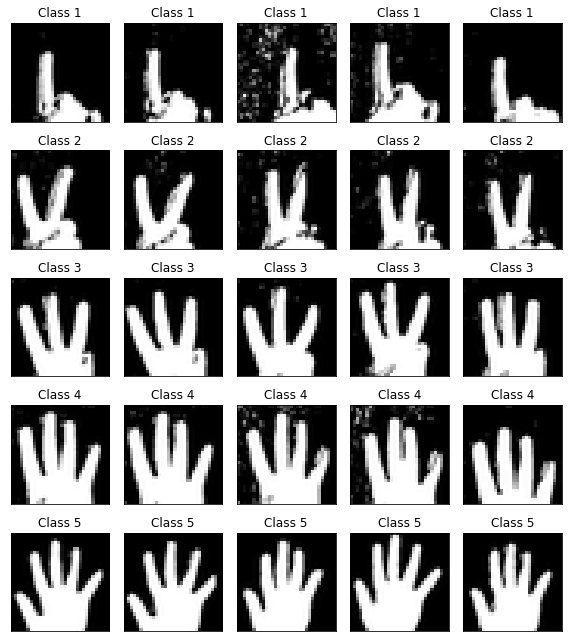

In [6]:
plt.figure(figsize=(8, 9))
cnt = 1
for i in range(5):
    for img in C[i]:
        plt.subplot(5, 5, cnt)
        plt.imshow(img,cmap='gray'), plt.xticks([]), plt.yticks([])
        plt.title('Class {}'.format(i+1))
        cnt += 1
        if cnt%5 == 1:
            break
plt.tight_layout()
plt.show()

In [7]:
images = np.reshape(C, (1005, 32, 32))

In [8]:
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 256

normalized_images = (images*255.0 - 127.5)/127.5
train_dataset = tf.data.Dataset.from_tensor_slices(normalized_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# AC-GAN

In [9]:
def make_generator(noise,labels):
    g = keras.layers.Concatenate()([noise, labels])
    g = (layers.Dense(8*8*256,activation="relu", input_shape=[105,]))(g)
    g = (layers.BatchNormalization())(g)
    g = (layers.Reshape([8, 8, 256]))(g)
    g = (layers.BatchNormalization())(g)
    g = (layers.UpSampling2D())(g)
    g = (layers.Conv2D(128, kernel_size=3, padding="same"))(g)
    g = (layers.Activation("relu"))(g)
    g = (layers.BatchNormalization())(g)
    g = (layers.UpSampling2D())(g)
    g = (layers.Conv2D(64, kernel_size=3, padding="same"))(g)
    g = (layers.Activation("relu"))(g)
    g = (layers.BatchNormalization())(g)
    g = (layers.Conv2D(1, kernel_size=3, padding='same'))(g)
    out = (layers.Activation("tanh"))(g)

    return keras.models.Model([noise,labels],out)

In [10]:
def make_discriminator(input):     
    d = (layers.Conv2D(32, (3,3), strides=(2,2), padding='same', input_shape=[32, 32, 1]))(input)
    d = (layers.LeakyReLU(0.2))(d)
    d = (layers.Dropout(0.5))(d)
    d = (layers.Conv2D(64, (3,3), padding='same'))(d)
    d = (layers.BatchNormalization())(d)
    d = (layers.LeakyReLU(0.2))(d)
    d = (layers.Dropout(0.5))(d)
    d = (layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))(d)
    d = (layers.BatchNormalization())(d)
    d = (layers.LeakyReLU(0.2))(d)
    d = (layers.Dropout(0.5))(d)
    d = (layers.Conv2D(256, (3,3), padding='same'))(d)
    d = (layers.BatchNormalization())(d)
    d = (layers.LeakyReLU(0.2))(d)
    d = (layers.Dropout(0.5))(d)
    out = (layers.Flatten())(d)

    out1 = layers.Dense(1, activation='sigmoid')(out)
    out2 = layers.Dense(5, activation='softmax')(out)

    return keras.models.Model(input, [out1, out2])


In [11]:
def MAKE_ACGAN(input_shape = (32,32,1),noise_dim = 100, classes_num = 5):

    discriminator = make_discriminator(layers.Input(shape=input_shape))
    discriminator.compile(loss=['binary_crossentropy','categorical_crossentropy'],
    optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['accuracy'])
    discriminator.trainable = False

    generator = make_generator(layers.Input(shape=(noise_dim,)),layers.Input(shape=(classes_num,)))
    ACGAN_inputs = [layers.Input(shape=(noise_dim,)),layers.Input(shape=(classes_num,))]
    ACGAN_output = discriminator(generator(ACGAN_inputs))
    ACGAN = keras.models.Model(ACGAN_inputs,ACGAN_output)
    ACGAN.compile(loss=['binary_crossentropy','categorical_crossentropy'],
    optimizer=tf.keras.optimizers.Adam(0.0001),metrics=['accuracy'])
    models = generator, discriminator, ACGAN
    AC_train(models)


In [12]:
def generate_and_save_images_2(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(6, 6))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.tight_layout()
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [13]:
seed = tf.random.normal([5, 100])
def AC_train(models,EPOCHS = 1000, BATCH_SIZE = 256, noise_dim=100 ):

    labels = np.zeros([1005,5])
    for i in range(1005):
        labels[i][int(i/201)] = 1

    discriminator_loss,discriminator_Real_Fake_loss,discriminator_Classification_loss = [],[],[]
    discriminator_Real_Fake_Accuracy,discriminator_Classification_Accuracy = [],[]

    ACGAN_loss,ACGAN_Real_Fake_loss,ACGAN_Classification_loss = [],[],[]
    ACGAN_Real_Fake_Accuracy,ACGAN_Classification_Accuracy = [],[]

    valid = np.ones((BATCH_SIZE,1))
    fake  = np.zeros((BATCH_SIZE,1))
    generator, discriminator, ACGAN = models
    batch_cnt = normalized_images.shape[0]//BATCH_SIZE
    for epoch in range(EPOCHS):
      for i in range(batch_cnt):
        noise = np.random.normal(0, 1, (BATCH_SIZE, 100))
        batch_images = normalized_images[i*BATCH_SIZE:(i+1)*BATCH_SIZE].reshape(-1,32,32,1)
        batch_labels = labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
        sampled_labels = np.random.randint(0, 5, (BATCH_SIZE, 1))
        sampled_labels = np.array(sampled_labels)
        fake_labels = keras.utils.to_categorical(sampled_labels) 

        gen_out = generator.predict([noise,fake_labels],verbose = 1)
        disc_images = np.concatenate([batch_images,gen_out])  
        disc_real_or_fake_label = np.concatenate([valid,fake])
        disc_class_label = np.concatenate([batch_labels,fake_labels])
        dl,drfl,dcl,drfa,dla = discriminator.train_on_batch(disc_images,[disc_real_or_fake_label,disc_class_label]);
        ACloss,ACrfloss,ACll,ACrfa,ACla = ACGAN.train_on_batch([noise,fake_labels],[valid,fake_labels]);

      discriminator_loss.append(dl); discriminator_Real_Fake_loss.append(drfl)
      discriminator_Classification_loss.append(dcl);discriminator_Real_Fake_Accuracy.append(drfa*100)
      discriminator_Classification_Accuracy.append(dla)
      ACGAN_loss.append(ACloss);ACGAN_Real_Fake_loss.append(ACrfloss)
      ACGAN_Classification_loss.append(ACll);ACGAN_Real_Fake_Accuracy.append(ACrfa*100)
      ACGAN_Classification_Accuracy.append(ACla)

      y_test = [[0],[1],[2],[3],[4]]
      y_test = keras.utils.to_categorical(y_test)
      if (epoch)%30 == 0:
        display.clear_output(wait=True)
        generate_and_save_images_2(generator,epoch,[np.random.normal(size=(5,100)),y_test])
        print('Epoch = ',str(epoch))
    display.clear_output(wait=True)
    generate_and_save_images_2(generator,epoch,[np.random.normal(size=(5,100)),y_test])

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(discriminator_loss)
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.title('Discriminator Loss')
    plt.subplot(1, 2, 2)
    plt.plot(discriminator_Real_Fake_Accuracy)
    plt.xlabel('Epochs'), plt.ylabel('Accuracy')
    plt.title('Discriminator Accuracy')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ACGAN_loss)
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.title('Generator Loss')
    plt.subplot(1, 2, 2)
    plt.plot(ACGAN_Real_Fake_Accuracy)
    plt.xlabel('Epochs'), plt.ylabel('Accuracy')
    plt.title('Generator Accuracy')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(discriminator_Classification_loss)
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.title('Discriminator Classification Loss')
    plt.subplot(1, 2, 2)
    plt.plot(discriminator_Classification_Accuracy)
    plt.xlabel('Epochs'), plt.ylabel('Accuracy')
    plt.title('Discriminator Classification Accuracy')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(ACGAN_Classification_loss)
    plt.xlabel('Epochs'), plt.ylabel('Loss')
    plt.title('ACGAN Classification Loss')
    plt.subplot(1, 2, 2)
    plt.plot(ACGAN_Classification_Accuracy)
    plt.xlabel('Epochs'), plt.ylabel('Accuracy')
    plt.title('ACGAN Classification Accuracy')
    plt.tight_layout()
    plt.show()


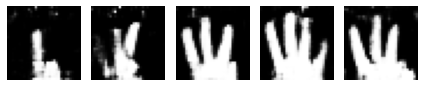

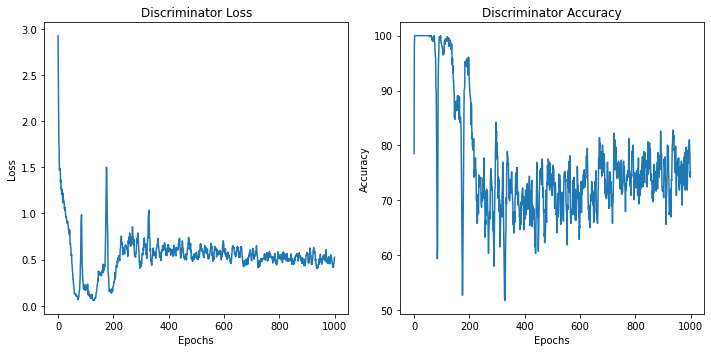

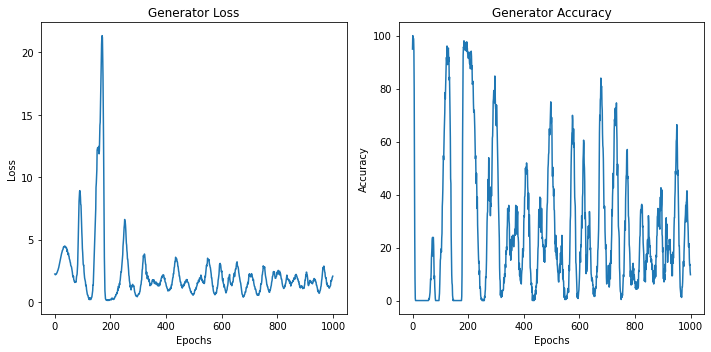

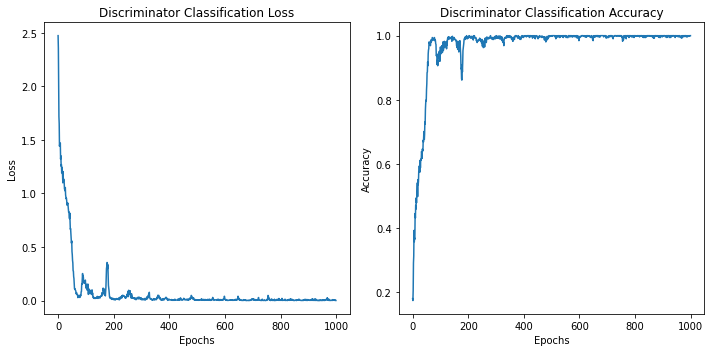

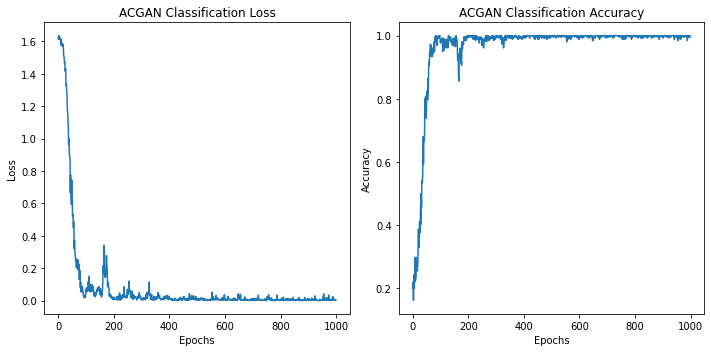

In [14]:
MAKE_ACGAN()

In [15]:
anim_file = 'acgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)